# Optional: Visualize the collection

# Get annual Landsat images for 1992-2021

# Get first buffered polygon and convert to GEE geometry

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
mining = gpd.read_file("/Users/felixschulz/Downloads/global_mining_polygons_v2.gpkg")

In [3]:
mining_subset = mining.query("ISO3_CODE == 'ZAF'").copy()

In [ ]:
envelopes = mining_subset.buffer(.05, cap_style="square").envelope
#
intersection_area = envelopes.apply(lambda geom: geom.intersection(envelopes).area)


In [35]:
# criterion
overlap_matrix = intersection_area > 0.75 * envelopes.area
# transitive clustering
from scipy.sparse.csgraph import connected_components
n_components, labels = connected_components(overlap_matrix.values, directed=False, return_labels=True)
# assign cluster labels
mining_subset["cluster"] = labels

/var/folders/56/097r5m_53z97wd0wwmqws76m0000gn/T/ipykernel_2235/633439660.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap_matrix = intersection_area > 0.75 * envelopes.area


/var/folders/56/097r5m_53z97wd0wwmqws76m0000gn/T/ipykernel_29152/3852755636.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mining_subset.buffer(.05, cap_style="square").envelope.plot()


<Axes: >

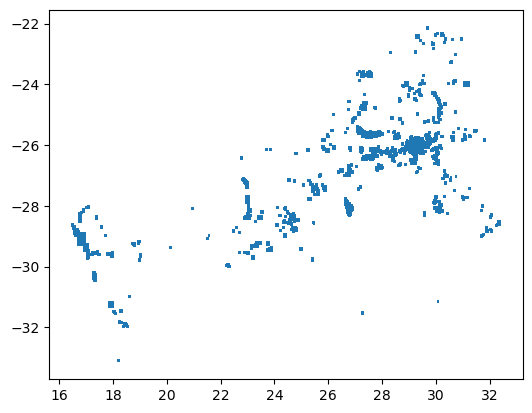

In [67]:
mining_subset.buffer(.05, cap_style="square").envelope.plot()

In [2]:
import ee
ee.Initialize(project="ee-growthandheat")

In [39]:
# Get first polygon and buffer it
first_polygon = mining_subset.iloc[0:1].buffer(0.05).envelope

# Convert to GeoJSON format for GEE
geojson = first_polygon.geometry.iloc[0].__geo_interface__

# Create GEE geometry
roi = ee.Geometry(geojson)

/var/folders/56/097r5m_53z97wd0wwmqws76m0000gn/T/ipykernel_29152/3877488884.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  first_polygon = mining_subset.iloc[0:1].buffer(0.05).envelope


In [40]:
# Get Landsat annual composites from 1992 to 2021
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_COMPOSITES_C02_T1_L2_ANNUAL?hl=de#terms-of-use
dataset = ee.ImageCollection('LANDSAT/COMPOSITES/C02/T1_L2_ANNUAL') \
    .filterDate('1992-01-01', '2022-01-01') \
    .filterBounds(roi)

# Get the size of the collection
print(f"Number of images: {dataset.size().getInfo()}")

# Get list of years
years = dataset.aggregate_array('system:index').getInfo()
print(f"Available years: {years}")

Number of images: 30
Available years: ['1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [41]:
# Example: Get a specific year's image (e.g., 2020)
image_2020 = dataset.filterDate('2020-01-01', '2021-01-01').first()


In [50]:
(30 * 31 * 45000) / 60 / 60

11625.0

In [45]:
# Export all years to Google Drive at full resolution (30m)
# Define output folder and naming scheme
drive_folder = "landsat_mining_ZAF"
country_code = mining_subset.iloc[0]['ISO3_CODE']

# Create export tasks for all years
export_tasks = []

for year in range(1992, 2022):
    year_image = dataset.filterDate(f'{year}-01-01', f'{year+1}-01-01').first()
    
    if year_image is not None:
        # Clip to ROI and prepare for export
        clipped_image = year_image.clip(roi)
        
        # Create informative filename
        filename = f"LANDSAT_C02_T1_L2_ANNUAL_{country_code}_{year}_30m"
        
        # Create export task
        task = ee.batch.Export.image.toDrive(
            image=clipped_image,
            description=filename,
            folder=drive_folder,
            fileNamePrefix=filename,
            scale=30,  # Full resolution
            crs='EPSG:4326',
            fileFormat='GeoTIFF',
            maxPixels=1e13  # Allow large exports
        )
        
        # Start the task
        task.start()
        export_tasks.append((year, task))
    else:
        print(f"No image available for {year}")

print(f"\nTotal tasks started: {len(export_tasks)}")
print(f"Check your Google Drive folder '{drive_folder}' for the downloads")

Started export for 1992: LANDSAT_C02_T1_L2_ANNUAL_ZAF_1992_30m
Started export for 1993: LANDSAT_C02_T1_L2_ANNUAL_ZAF_1993_30m
Started export for 1994: LANDSAT_C02_T1_L2_ANNUAL_ZAF_1994_30m
Started export for 1995: LANDSAT_C02_T1_L2_ANNUAL_ZAF_1995_30m
Started export for 1996: LANDSAT_C02_T1_L2_ANNUAL_ZAF_1996_30m
Started export for 1997: LANDSAT_C02_T1_L2_ANNUAL_ZAF_1997_30m
Started export for 1998: LANDSAT_C02_T1_L2_ANNUAL_ZAF_1998_30m
Started export for 1999: LANDSAT_C02_T1_L2_ANNUAL_ZAF_1999_30m
Started export for 2000: LANDSAT_C02_T1_L2_ANNUAL_ZAF_2000_30m
Started export for 2001: LANDSAT_C02_T1_L2_ANNUAL_ZAF_2001_30m
Started export for 2002: LANDSAT_C02_T1_L2_ANNUAL_ZAF_2002_30m
Started export for 2003: LANDSAT_C02_T1_L2_ANNUAL_ZAF_2003_30m
Started export for 2004: LANDSAT_C02_T1_L2_ANNUAL_ZAF_2004_30m
Started export for 2005: LANDSAT_C02_T1_L2_ANNUAL_ZAF_2005_30m
Started export for 2006: LANDSAT_C02_T1_L2_ANNUAL_ZAF_2006_30m
Started export for 2007: LANDSAT_C02_T1_L2_ANNUAL_ZAF_2

In [52]:
# Download all files from Google Drive folder (local setup)
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import os
import pickle
import io
from pathlib import Path

SCOPES = ['https://www.googleapis.com/auth/drive']
creds = None

# Load or create credentials
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)

if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        # Make sure you have credentials.json in the current directory
        # Download from: https://console.developers.google.com/apis/credentials
        flow = InstalledAppFlow.from_client_secrets_file(
            'client_secret_526597105234-njqmlfj2jcr8342lsouu8o69cdk1k6ue.apps.googleusercontent.com.json', SCOPES)
        creds = flow.run_local_server(port=0)
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=526597105234-njqmlfj2jcr8342lsouu8o69cdk1k6ue.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A61531%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.readonly&state=T2fG2PHxFvdH9NKgcp7IzAsQ6oLMOs&access_type=offline


In [54]:

drive_service = build('drive', 'v3', credentials=creds)

# Create local output directory
local_output_dir = Path("./landsat_data")
local_output_dir.mkdir(exist_ok=True)

# Find the folder by name
folder_query = f"name='{drive_folder}' and mimeType='application/vnd.google-apps.folder' and trashed=false"
folder_results = drive_service.files().list(
    q=folder_query,
    spaces='drive',
    fields='files(id, name)',
    pageSize=10
).execute()

folders = folder_results.get('files', [])
if not folders:
    print(f"Folder '{drive_folder}' not found on Google Drive")
else:
    folder_id = folders[0]['id']
    print(f"Found folder: {folders[0]['name']} (ID: {folder_id})")
    
    # List all files in the folder
    file_query = f"'{folder_id}' in parents and trashed=false"
    file_results = drive_service.files().list(
        q=file_query,
        spaces='drive',
        fields='files(id, name, mimeType)',
        pageSize=100
    ).execute()
    
    files = file_results.get('files', [])
    print(f"\nDownloading {len(files)} files...")
    
    # Download each file
    deleted_count = 0
    for file in files:
        if 'GeoTIFF' in file['mimeType'] or file['name'].endswith('.tif'):
            file_id = file['id']
            filename = file['name']
            filepath = local_output_dir / filename
            
            # Download the file
            request = drive_service.files().get_media(fileId=file_id)
            fh = io.FileIO(filepath, 'wb')
            downloader = MediaIoBaseDownload(fh, request)
            
            done = False
            while not done:
                status, done = downloader.next_chunk()
                if status:
                    print(f"  {filename}: {int(status.progress() * 100)}%")
            
            fh.close()
            print(f"✓ Downloaded: {filepath}")
            
            # Delete file from Google Drive after successful download
            try:
                drive_service.files().delete(fileId=file_id).execute()
                print(f"  Deleted from Drive: {filename}")
                deleted_count += 1
            except Exception as e:
                print(f"  Warning: Could not delete {filename}: {e}")
    
    print(f"\nAll files downloaded to: {local_output_dir.absolute()}")
    print(f"Deleted {deleted_count} files from Google Drive")

Found folder: landsat_mining_ZAF (ID: 1yqd2MdCq4rfZBnYQ0uUM8VXakMhcbuv4)

  LANDSAT_C02_T1_L2_ANNUAL_ZAF_2021_30m.tif: 100%
✓ Downloaded: landsat_data/LANDSAT_C02_T1_L2_ANNUAL_ZAF_2021_30m.tif
  LANDSAT_C02_T1_L2_ANNUAL_ZAF_2019_30m.tif: 100%
✓ Downloaded: landsat_data/LANDSAT_C02_T1_L2_ANNUAL_ZAF_2019_30m.tif
  LANDSAT_C02_T1_L2_ANNUAL_ZAF_2020_30m.tif: 100%
✓ Downloaded: landsat_data/LANDSAT_C02_T1_L2_ANNUAL_ZAF_2020_30m.tif
  LANDSAT_C02_T1_L2_ANNUAL_ZAF_2016_30m.tif: 100%
✓ Downloaded: landsat_data/LANDSAT_C02_T1_L2_ANNUAL_ZAF_2016_30m.tif
  LANDSAT_C02_T1_L2_ANNUAL_ZAF_2018_30m.tif: 100%
✓ Downloaded: landsat_data/LANDSAT_C02_T1_L2_ANNUAL_ZAF_2018_30m.tif


KeyboardInterrupt: 

---

In [23]:
import xarray as xr
import rioxarray as rxr
from odc.geo.xr import ODCExtensionDa
from odc.geo.geom import Geometry

In [5]:
image = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Job/UNI/Basel/Research/growth-and-temperature/gnt/experiments/landsat_data/LANDSAT_C02_T1_L2_ANNUAL_ZAF_2016_30m.tif")

In [6]:
image

<xarray.DataArray (band: 7, y: 404, x: 398)> Size: 9MB
[1125544 values with dtype=float64]
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * y            (y) float64 3kB -31.48 -31.48 -31.48 ... -31.59 -31.59 -31.59
  * x            (x) float64 3kB 27.22 27.22 27.22 27.22 ... 27.32 27.32 27.32
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

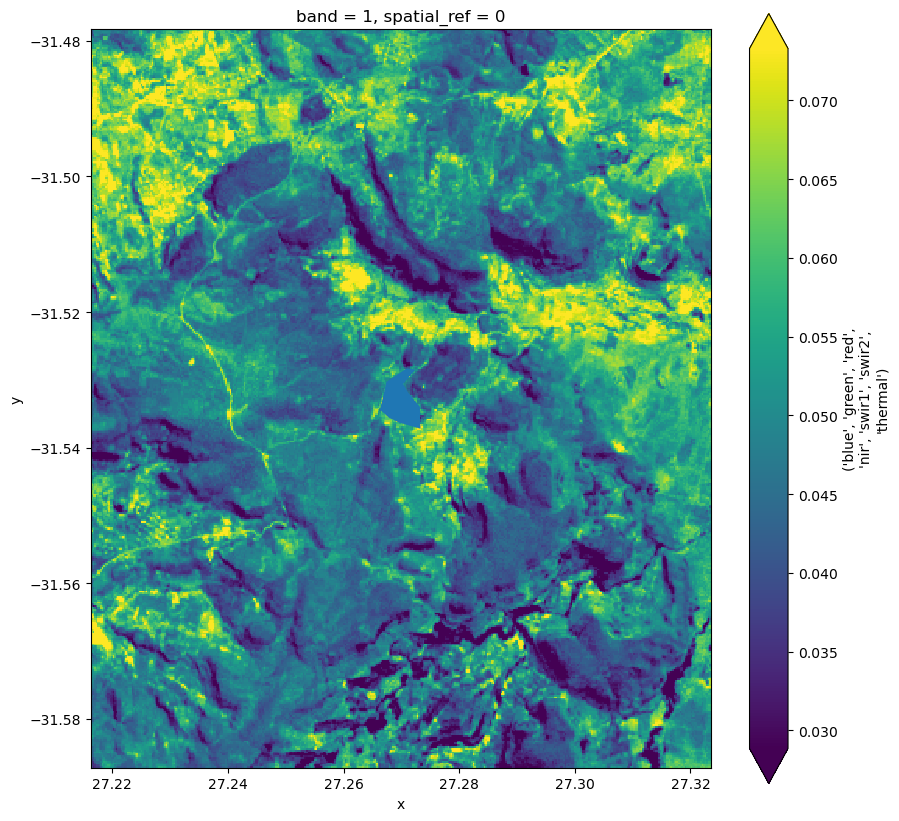

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

image.isel(band=0).odc.mask(Geometry(first_polygon.iloc[0], 4326)).plot.imshow(ax=ax, robust=True)
mining_subset.iloc[[0]].plot(ax=ax)

In [12]:
from odc.geo.geom import Geometry
from odc.geo.geobox import GeoBox, GeoboxTiles, geobox_union_conservative

In [29]:
world_geobox = GeoBox.from_bbox(
    [-180, -90, 180, 90],
    resolution=0.000269495,
    crs=4326
    )

world_geobox_tiles = GeoboxTiles(world_geobox, [64, 64])

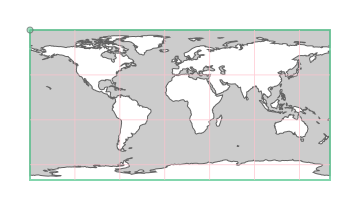

In [30]:
world_geobox

In [32]:
test = xr.open_zarr("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Job/UNI/Basel/Research/growth-and-temperature/data/mining_segmentation/global_landsat.zarr")

/var/folders/56/097r5m_53z97wd0wwmqws76m0000gn/T/ipykernel_33983/1730904961.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  test = xr.open_zarr("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Job/UNI/Basel/Research/growth-and-temperature/data/mining_segmentation/global_landsat.zarr")


In [36]:
np.isin(test.coords["latitude"].values, np.array([64.1801 , 64.17983, 64.17956, 64.17929, 64.17902, 64.17875,
       64.17848, 64.17821, 64.17794, 64.17767, 64.1774 , 64.17714,
       64.17687, 64.1766 , 64.17633, 64.17606, 64.17579, 64.17552,
       64.17525, 64.17498, 64.17471, 64.17444, 64.17417, 64.1739 ,
       64.17363, 64.17336, 64.17309, 64.17282, 64.17255, 64.17228,
       64.17201, 64.17175, 64.17148, 64.17121, 64.17094, 64.17067,
       64.1704 , 64.17013, 64.16986, 64.16959, 64.16932, 64.16905,
       64.16878, 64.16851, 64.16824, 64.16797, 64.1677 , 64.16743,
       64.16716, 64.16689, 64.16662, 64.16636, 64.16609, 64.16582,
       64.16555, 64.16528, 64.16501, 64.16474, 64.16447, 64.1642 ,
       64.16393, 64.16366, 64.16339, 64.16312]))

array([False, False, False, ..., False, False, False], shape=(667916,))

OrderedDict([('latitude',
              Coordinate(values=array([ 89.99987646,  89.99960697,  89.99933747, ..., -89.99933747,
                     -89.99960697, -89.99987646], shape=(667916,)), units='degrees_north', resolution=-0.000269495)),
             ('longitude',
              Coordinate(values=array([-179.99988767, -179.99961818, -179.99934868, ...,  179.99934868,
                      179.99961818,  179.99988767], shape=(1335832,)), units='degrees_east', resolution=0.000269495))])

In [41]:
test.coords["latitude"].values[test.coords["latitude"].values > 64.16312]

array([90.00001, 89.99974, 89.99947, ..., 64.1638 , 64.16353, 64.16326],
      shape=(95872,))

In [38]:
test.coords["latitude"].values > 64.1801

array([ True,  True,  True, ..., False, False, False], shape=(667916,))

In [ ]:
from shapely import MultiPolygon
rasterize(Geometry(MultiPolygon(geoms), 4326), tile_geobox)

NameError: name 'world_geobox' is not defined

In [ ]:
gpd.GeoSeries([world_geobox_tiles[val["tile_ix"], val["tile_iy"]].extent for _, val in tiles_df_.iterrows()]).total_bounds
# -> use this for GEE query

array([ 27.2136051 , -31.59613279,  27.33433886, -31.47539903])

In [238]:
tiles_df_.iloc[0][["tile_ix", "tile_iy"]].tolist()

[np.int64(7043), np.int64(12014)]

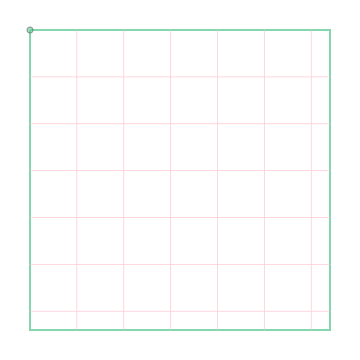

In [ ]:
image.odc.reproject(world_geobox_tiles[int(tiles_df_.iloc[10]["tile_ix"]), int(tiles_df_.iloc[10]["tile_iy"])].extent)

<xarray.DataArray (band: 7, y: 65, x: 65)> Size: 237kB
array([[[6.60075000e-02, 6.61725000e-02, 6.27212500e-02, ...,
         4.21650000e-02, 4.68400000e-02, 4.95900000e-02],
        [6.30650000e-02, 6.50175000e-02, 6.30650000e-02, ...,
         4.40350000e-02, 4.86825000e-02, 5.03325000e-02],
        [5.99850000e-02, 5.96825000e-02, 5.93250000e-02, ...,
         4.52725000e-02, 4.85175000e-02, 5.25600000e-02],
        ...,
        [3.79575000e-02, 4.03225000e-02, 3.73525000e-02, ...,
         4.35950000e-02, 4.37600000e-02, 4.37600000e-02],
        [3.80262500e-02, 3.88787500e-02, 3.75862500e-02, ...,
         4.37600000e-02, 4.27425000e-02, 4.27425000e-02],
        [3.66925000e-02, 3.75725000e-02, 3.88925000e-02, ...,
         4.37187500e-02, 4.31962500e-02, 4.31962500e-02]],

       [[1.00492500e-01, 9.93375000e-02, 9.49650000e-02, ...,
         7.14937500e-02, 7.40787500e-02, 7.69800000e-02],
        [9.55425000e-02, 9.93375000e-02, 9.55425000e-02, ...,
         7.08750000e-02, 7.44225000e-02, 7.89050000e-02],
        [9.37000000e-02, 9.49237500e-02, 9.04962500e-02, ...,
         7.08475000e-02, 7.57700000e-02, 7.76125000e-02],
...
         1.86320000e-01, 2.07687500e-01, 2.07687500e-01],
        [1.56235000e-01, 1.78097500e-01, 1.87227500e-01, ...,
         1.88025000e-01, 1.95147500e-01, 1.95147500e-01],
        [1.47380000e-01, 1.65227500e-01, 1.81370000e-01, ...,
         1.90225000e-01, 1.84697500e-01, 1.84697500e-01]],

       [[3.01611175e+02, 3.01611175e+02, 3.01064292e+02, ...,
         3.01973485e+02, 3.02084571e+02, 3.02250345e+02],
        [3.01559905e+02, 3.01570159e+02, 3.00972005e+02, ...,
         3.01529143e+02, 3.01853854e+02, 3.01853854e+02],
        [3.01474454e+02, 3.01493253e+02, 3.00857502e+02, ...,
         3.01529143e+02, 3.01853854e+02, 3.01853854e+02],
        ...,
        [2.99529601e+02, 3.00161935e+02, 2.99669740e+02, ...,
         3.00763506e+02, 3.00954915e+02, 3.00954915e+02],
        [2.98731493e+02, 2.99570617e+02, 2.99826969e+02, ...,
         3.00599441e+02, 3.00917317e+02, 3.00917317e+02],
        [2.98893849e+02, 2.99844059e+02, 3.00264475e+02, ...,
         3.00623367e+02, 3.00746416e+02, 3.00746416e+02]]],
      shape=(7, 65, 65))
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * y            (y) float64 520B -31.49 -31.49 -31.49 ... -31.51 -31.51 -31.51
  * x            (x) float64 520B 27.27 27.27 27.27 27.27 ... 27.28 27.28 27.28
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal')

In [231]:
image

<xarray.DataArray (band: 7, y: 404, x: 398)> Size: 9MB
[1125544 values with dtype=float64]
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * y            (y) float64 3kB -31.48 -31.48 -31.48 ... -31.59 -31.59 -31.59
  * x            (x) float64 3kB 27.22 27.22 27.22 27.22 ... 27.32 27.32 27.32
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      ('blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal')

## Reset ICL Tasks to Pre-Download Status

Reset all Iceland (ISL) tasks to STATUS_COMPLETED for testing the download pipeline.


In [21]:
import sqlite3
from pathlib import Path

db_path = Path("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Job/UNI/Basel/Research/growth-and-temperature/data/mining_segmentation/mining_segmentation.db")

# Connect to database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Update all ISL tasks to STATUS_COMPLETED (pre-download state)
STATUS_COMPLETED = "completed"
country_code = "ISL"

cursor.execute(
    """
    UPDATE tasks 
    SET status = ?, 
        drive_file_id = NULL,
        drive_filename = NULL,
        local_filepath = NULL,
        zarr_region_path = NULL,
        downloaded_at = NULL,
        reprojected_at = NULL
    WHERE country_code = ? AND status != ?
    """,
    (STATUS_COMPLETED, country_code, "pending")
)

updated = cursor.rowcount
conn.commit()

# Show results
cursor.execute("SELECT COUNT(*) FROM tasks WHERE country_code = ?", (country_code,))
total = cursor.fetchone()[0]

cursor.execute("SELECT status, COUNT(*) FROM tasks WHERE country_code = ? GROUP BY status", (country_code,))
status_counts = cursor.fetchall()

conn.close()

print(f"✓ Reset {updated} ISL tasks to pre-download status")
print(f"\nISL task summary ({total} total):")
for status, count in status_counts:
    print(f"  {status}: {count}")


✓ Reset 1 ISL tasks to pre-download status

ISL task summary (1 total):
  completed: 1
